<a href="https://colab.research.google.com/github/kovacsmaja/szakdolgozat/blob/main/kangaroo_care_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install adjustText -q

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
from adjustText import adjust_text
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'DejaVu Sans'

In [3]:
# DATA IMPORT AND PREPARATION

df = pd.read_excel('baby_observation.xlsx', sheet_name='sheet1')

baby_cols_before = [c for c in df.columns if 'before' in c.lower()]
baby_cols_after = [c for c in df.columns if 'after' in c.lower()]

babies = []
for col in baby_cols_before:
    baby_id = col.replace('_before', '').replace('_Before', '')
    babies.append(baby_id)

print(f"Data imported successfully!")
print(f"Number of babies: {len(babies)}")
print(f"Baby IDs: {babies}")

Data imported successfully!
Number of babies: 10
Baby IDs: ['10kk', '40kk', '90KK', '70kk', '80kk', '20jj', '20en', '60jj', '70jj', '20kk']


Number of stress signals (type=0): 26
Number of self-regulatory signals (type=1): 16

Stress signals:
baby  stress_before  stress_after  stress_change
10kk            8.0           4.0           -4.0
40kk           13.0           9.0           -4.0
90KK           15.0           8.0           -7.0
70kk            1.0           0.0           -1.0
80kk           14.0           7.0           -7.0
20jj           11.0           6.0           -5.0
20en            5.0           2.0           -3.0
60jj            4.0           2.0           -2.0
70jj            3.0           2.0           -1.0
20kk           13.0           1.0          -12.0

Self-regulatory signals:
baby  selfreg_before  selfreg_after  selfreg_change
10kk             6.0           10.0             4.0
40kk             5.0            8.0             3.0
90KK             9.0           10.0             1.0
70kk             2.0            3.0             1.0
80kk             3.0           10.0             7.0
20jj             0.0 

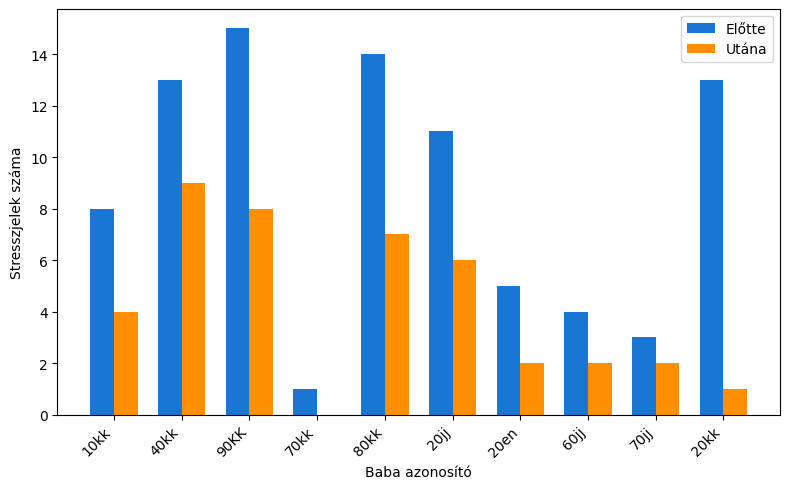

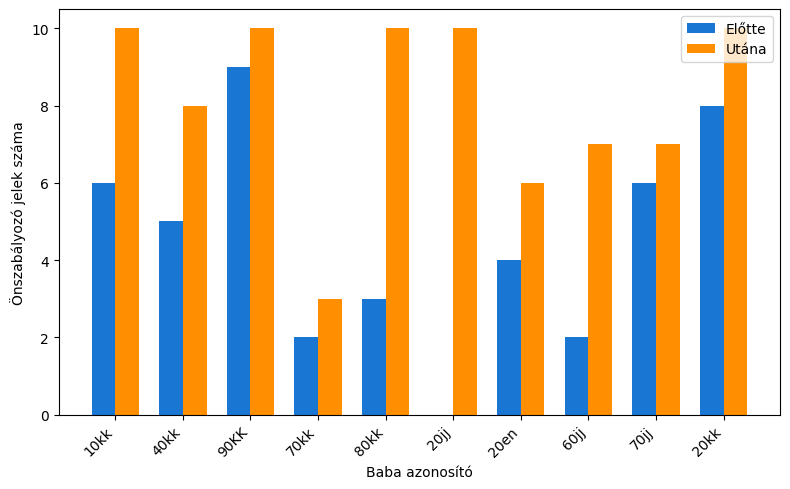

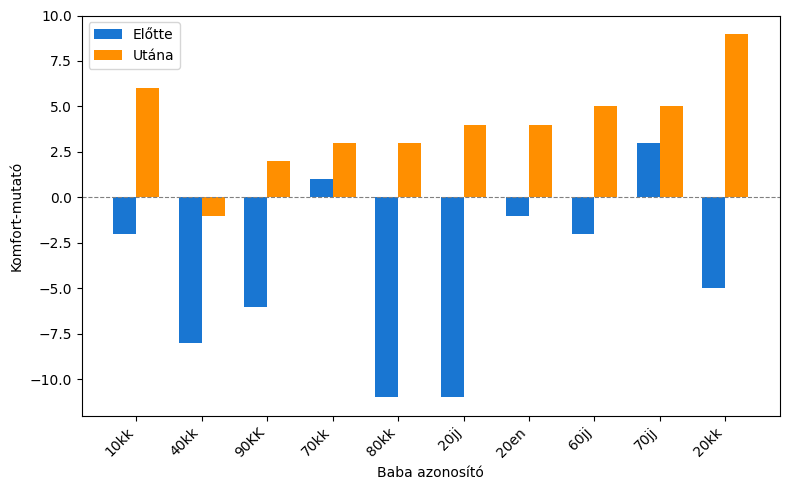

In [4]:
# 1.ANALYSIS: STRESS AND SELF-REGULATORY SIGNALS

nidcap_df = df[df['scale'] == 'NIDCAP'].copy()

stress_df = nidcap_df[nidcap_df['type'] == 0]
selfreg_df = nidcap_df[nidcap_df['type'] == 1]

print(f"Number of stress signals (type=0): {len(stress_df)}")
print(f"Number of self-regulatory signals (type=1): {len(selfreg_df)}")

results = []

for i, baby in enumerate(babies):
    before_col = baby_cols_before[i]
    after_col = baby_cols_after[i]

    stress_before = stress_df[before_col].sum()
    stress_after = stress_df[after_col].sum()

    selfreg_before = selfreg_df[before_col].sum()
    selfreg_after = selfreg_df[after_col].sum()

    stress_change = stress_after - stress_before
    selfreg_change = selfreg_after - selfreg_before

    comfort_before = selfreg_before - stress_before
    comfort_after = selfreg_after - stress_after
    comfort_change = comfort_after - comfort_before

    results.append({
        'baby': baby,
        'stress_before': stress_before,
        'stress_after': stress_after,
        'stress_change': stress_change,
        'selfreg_before': selfreg_before,
        'selfreg_after': selfreg_after,
        'selfreg_change': selfreg_change,
        'comfort_before': comfort_before,
        'comfort_after': comfort_after,
        'comfort_change': comfort_change
    })

results_df = pd.DataFrame(results)

print("\nStress signals:")
print(results_df[['baby', 'stress_before', 'stress_after', 'stress_change']].to_string(index=False))

print("\nSelf-regulatory signals:")
print(results_df[['baby', 'selfreg_before', 'selfreg_after', 'selfreg_change']].to_string(index=False))

print("\nComfort indicator (selfreg - stress):")
print(results_df[['baby', 'comfort_before', 'comfort_after', 'comfort_change']].to_string(index=False))

# Summary
improved = (results_df['comfort_change'] > 0).sum()
worsened = (results_df['comfort_change'] < 0).sum()
unchanged = (results_df['comfort_change'] == 0).sum()

print(f"\nSUMMARY:")
print(f"  Improved (comfort_change > 0): {improved} babies")
print(f"  Worsened (comfort_change < 0): {worsened} babies")
print(f"  Unchanged: {unchanged} babies")

# Wilcoxon signed-rank test
stat, p_value = stats.wilcoxon(results_df['comfort_before'],
                               results_df['comfort_after'],
                               alternative='less')

print(f"\nWilcoxon signed-rank test:")
print(f"  Test statistic: {stat}")
print(f"  p-value (one-sided): {p_value:.4f}")
if p_value < 0.05:
    print("  → Significant improvement (p < 0.05)")
else:
    print("  → Not significant (p >= 0.05)")

# Visualization
fig1, ax1 = plt.subplots(figsize=(8, 5))
x = range(len(babies))
width = 0.35
ax1.bar([i - width/2 for i in x], results_df['stress_before'], width, label='Előtte', color='#1976D2')
ax1.bar([i + width/2 for i in x], results_df['stress_after'], width, label='Utána', color='#FF8F00')
ax1.set_xlabel('Baba azonosító')
ax1.set_ylabel('Stresszjelek száma')
ax1.set_xticks(x)
ax1.set_xticklabels(babies, rotation=45, ha='right')
ax1.legend()
plt.tight_layout()
plt.savefig('1_stress.png', dpi=150, bbox_inches='tight')
plt.show()

fig2, ax2 = plt.subplots(figsize=(8, 5))
ax2.bar([i - width/2 for i in x], results_df['selfreg_before'], width, label='Előtte', color='#1976D2')
ax2.bar([i + width/2 for i in x], results_df['selfreg_after'], width, label='Utána', color='#FF8F00')
ax2.set_xlabel('Baba azonosító')
ax2.set_ylabel('Önszabályozó jelek száma')
ax2.set_xticks(x)
ax2.set_xticklabels(babies, rotation=45, ha='right')
ax2.legend()
plt.tight_layout()
plt.savefig('1_selfreg.png', dpi=150, bbox_inches='tight')
plt.show()

fig3, ax3 = plt.subplots(figsize=(8, 5))
ax3.bar([i - width/2 for i in x], results_df['comfort_before'], width, label='Előtte', color='#1976D2')
ax3.bar([i + width/2 for i in x], results_df['comfort_after'], width, label='Utána', color='#FF8F00')
ax3.set_xlabel('Baba azonosító')
ax3.set_ylabel('Komfort-mutató')
ax3.set_xticks(x)
ax3.set_xticklabels(babies, rotation=45, ha='right')
ax3.legend()
ax3.axhline(y=0, color='gray', linestyle='--', linewidth=0.8)
plt.tight_layout()
plt.savefig('1_comfort.png', dpi=150, bbox_inches='tight')
plt.show()



N-PASS and NIDCAP comfort values:
baby  npass_before  npass_after  nidcap_comfort_before  nidcap_comfort_after
10kk           1.0          1.0                   -2.0                   6.0
40kk           4.0          3.0                   -8.0                  -1.0
90KK           3.0          1.0                   -6.0                   2.0
70kk           0.0          0.0                    1.0                   3.0
80kk           1.0          0.0                  -11.0                   3.0
20jj           1.0          1.0                  -11.0                   4.0
20en           0.0          0.0                   -1.0                   4.0
60jj           0.0          0.0                   -2.0                   5.0
70jj           1.0          0.0                    3.0                   5.0
20kk           4.0          1.0                   -5.0                   9.0

Spearman correlation (N-PASS vs NIDCAP comfort):
  Before: r = -0.515, p = 0.1278
  After:  r = -0.152, p = 0.6748
  

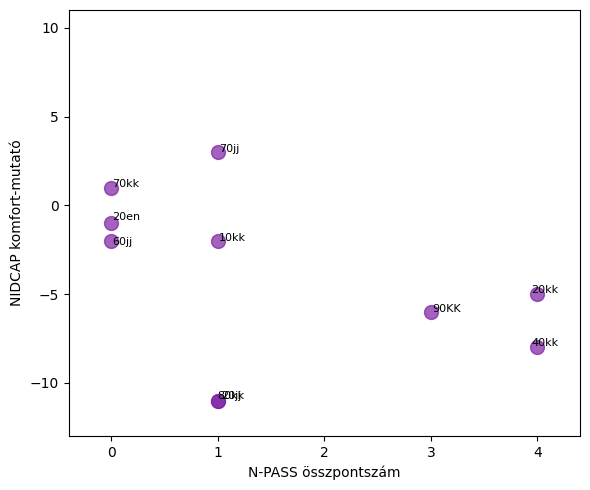

3 [ 0.91876786 -0.37159446]
4 [-0.8354784  -0.20892809]


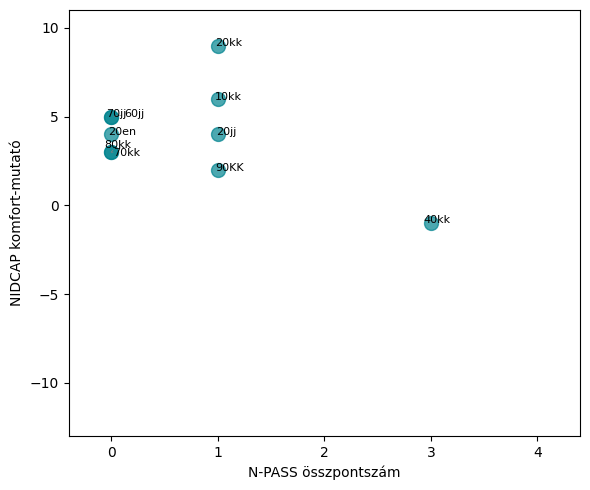

In [5]:
# 2.ANALYSIS: NIDCAP AND N-PASS CORRELATION

npass_df = df[df['scale'] == 'N-PASS']

npass_results = []

for i, baby in enumerate(babies):
    before_col = baby_cols_before[i]
    after_col = baby_cols_after[i]

    npass_before = npass_df[before_col].sum()
    npass_after = npass_df[after_col].sum()

    comfort_before = results_df.loc[results_df['baby'] == baby, 'comfort_before'].values[0]
    comfort_after = results_df.loc[results_df['baby'] == baby, 'comfort_after'].values[0]

    npass_results.append({
        'baby': baby,
        'npass_before': npass_before,
        'npass_after': npass_after,
        'nidcap_comfort_before': comfort_before,
        'nidcap_comfort_after': comfort_after
    })

npass_results_df = pd.DataFrame(npass_results)

print("\nN-PASS and NIDCAP comfort values:")
print(npass_results_df.to_string(index=False))

# Spearman correlation
corr_before, p_before = stats.spearmanr(npass_results_df['npass_before'],
                                         npass_results_df['nidcap_comfort_before'])

corr_after, p_after = stats.spearmanr(npass_results_df['npass_after'],
                                       npass_results_df['nidcap_comfort_after'])

all_npass = list(npass_results_df['npass_before']) + list(npass_results_df['npass_after'])
all_nidcap = list(npass_results_df['nidcap_comfort_before']) + list(npass_results_df['nidcap_comfort_after'])
corr_all, p_all = stats.spearmanr(all_npass, all_nidcap)

print(f"\nSpearman correlation (N-PASS vs NIDCAP comfort):")
print(f"  Before: r = {corr_before:.3f}, p = {p_before:.4f}")
print(f"  After:  r = {corr_after:.3f}, p = {p_after:.4f}")
print(f"  Combined: r = {corr_all:.3f}, p = {p_all:.4f}")

if corr_all < -0.5:
    print("\n→ Strong negative correlation")
elif corr_all < -0.3:
    print("\n→ Moderate negative correlation")
elif corr_all < 0:
    print("\n→ Weak negative correlation")
else:
    print("\n→ Unexpected positive/no correlation")

# Közös tengelyek meghatározása az összes adatból
x_min = min(all_npass)
x_max = max(all_npass)
y_min = min(all_nidcap)
y_max = max(all_nidcap)

# Kis margó hozzáadása
x_margin = (x_max - x_min) * 0.1
y_margin = (y_max - y_min) * 0.1

xlim = (x_min - x_margin, x_max + x_margin)
ylim = (y_min - y_margin, y_max + y_margin)

# Visualization
fig1, ax1 = plt.subplots(figsize=(6, 5))
ax1.scatter(npass_results_df['npass_before'], npass_results_df['nidcap_comfort_before'],
            s=100, alpha=0.7, color='#7B1FA2')

texts1 = []
for i, baby in enumerate(babies):
    texts1.append(ax1.text(npass_results_df['npass_before'].iloc[i],
                           npass_results_df['nidcap_comfort_before'].iloc[i],
                           baby, fontsize=8))
adjust_text(texts1, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

ax1.set_xlabel('N-PASS összpontszám')
ax1.set_ylabel('NIDCAP komfort-mutató')
ax1.set_xlim(xlim)
ax1.set_ylim(ylim)
plt.tight_layout()
plt.savefig('2_correlation_before.png', dpi=150, bbox_inches='tight')
plt.show()

fig2, ax2 = plt.subplots(figsize=(6, 5))
ax2.scatter(npass_results_df['npass_after'], npass_results_df['nidcap_comfort_after'],
            s=100, alpha=0.7, color='#00838F')

texts2 = []
for i, baby in enumerate(babies):
    texts2.append(ax2.text(npass_results_df['npass_after'].iloc[i],
                           npass_results_df['nidcap_comfort_after'].iloc[i],
                           baby, fontsize=8))
adjust_text(texts2, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

ax2.set_xlabel('N-PASS összpontszám')
ax2.set_ylabel('NIDCAP komfort-mutató')
ax2.set_xlim(xlim)
ax2.set_ylim(ylim)
plt.tight_layout()
plt.savefig('2_correlation_after.png', dpi=150, bbox_inches='tight')
plt.show()



NIDCAP category stress reduction:
category  n_criteria  stress_before  stress_after  absolute_change  percent_change  normalized_change
 Autonóm           7             26             9              -17      -65.384615          -0.242857
 Motoros          14             50            23              -27      -54.000000          -0.192857
Figyelem           5             11             9               -2      -18.181818          -0.040000


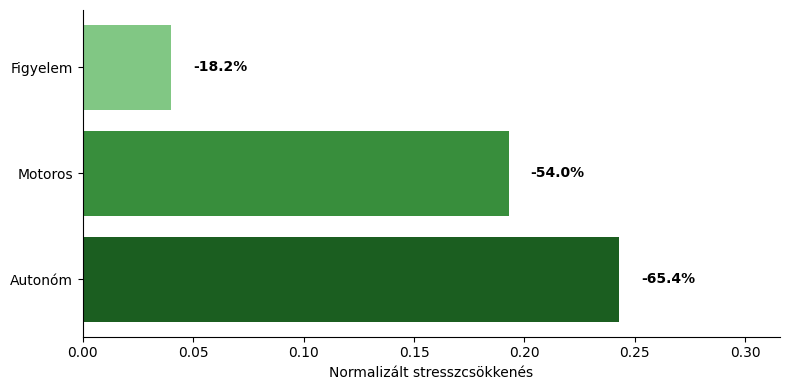

In [6]:
# 3. ANALYSIS: NIDCAP CATEGORY-LEVEL STRESS REDUCTION

stress_df = nidcap_df[nidcap_df['type'] == 0]

nidcap_categories = {
    'Autonóm': ['Légzés', 'Atutonóm instabilitással összefüggő motoros mintázatok'],
    'Motoros': ['Motoros', 'Arc', 'Végtagok'],
    'Figyelem': ['Figyelem']
}

category_results = []

for nidcap_cat, subcats in nidcap_categories.items():
    cat_stress = stress_df[stress_df['category'].isin(subcats)]
    n_criteria = len(cat_stress)

    if n_criteria == 0:
        continue

    total_before = 0
    total_after = 0

    for i, baby in enumerate(babies):
        before_col = baby_cols_before[i]
        after_col = baby_cols_after[i]

        total_before += cat_stress[before_col].sum()
        total_after += cat_stress[after_col].sum()

    abs_change = total_after - total_before
    pct_change = (abs_change / total_before) * 100 if total_before > 0 else 0
    avg_change_per_baby = abs_change / len(babies)
    normalized_change = avg_change_per_baby / n_criteria

    category_results.append({
        'category': nidcap_cat,
        'n_criteria': n_criteria,
        'stress_before': int(total_before),
        'stress_after': int(total_after),
        'absolute_change': int(abs_change),
        'percent_change': pct_change,
        'normalized_change': normalized_change
    })

category_df = pd.DataFrame(category_results)
category_df = category_df.sort_values('normalized_change')

print("\nNIDCAP category stress reduction:")
print(category_df.to_string(index=False))

# Visualization
fig, ax = plt.subplots(figsize=(8, 4))

category_df_sorted = category_df.sort_values('normalized_change', ascending=True)

colors = ['#1B5E20', '#388E3C', '#81C784']
bars = ax.barh(category_df_sorted['category'],
               abs(category_df_sorted['normalized_change']),
               color=colors)

for i, (idx, row) in enumerate(category_df_sorted.iterrows()):
    ax.text(abs(row['normalized_change']) + 0.01, i,
            f"{row['percent_change']:.1f}%",
            va='center', fontsize=10, fontweight='bold')

ax.set_xlabel('Normalizált stresszcsökkenés')
ax.set_xlim(0, max(abs(category_df['normalized_change'])) * 1.3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('3_nidcap_category_stress.png', dpi=150, bbox_inches='tight')
plt.show()


State distribution (number of babies):
       state         state_hu  before  after  change
 Quiet sleep    Csendes alvás       3      2      -1
Active sleep      Aktív alvás       5      0      -5
      Drowsy         Átmeneti       1      6       5
 Quiet awake Csendes ébrenlét       0      0       0
Active awake   Aktív ébrenlét       1      2       1
      Crying            Sírás       0      0       0


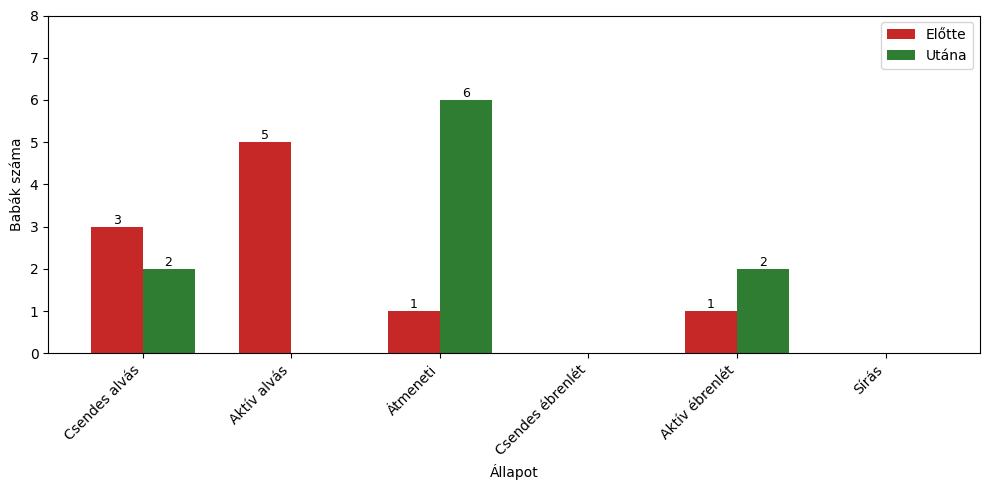

In [7]:
# 4. ANALYSIS: SLEEP-WAKE STATE CHANGES

state_df = nidcap_df[nidcap_df['category'] == 'Állapot']

state_order = ['Quiet sleep', 'Active sleep', 'Drowsy', 'Quiet awake', 'Active awake', 'Crying']
state_labels_hu = ['Csendes alvás', 'Aktív alvás', 'Átmeneti', 'Csendes ébrenlét', 'Aktív ébrenlét', 'Sírás']

state_counts_before = {s: 0 for s in state_order}
state_counts_after = {s: 0 for s in state_order}

for i, baby in enumerate(babies):
    before_col = baby_cols_before[i]
    after_col = baby_cols_after[i]

    for _, row in state_df.iterrows():
        state = row['criterion']
        if state in state_order:
            if row[before_col] == 1:
                state_counts_before[state] += 1
            if row[after_col] == 1:
                state_counts_after[state] += 1

state_results = []
for i, state in enumerate(state_order):
    state_results.append({
        'state': state,
        'state_hu': state_labels_hu[i],
        'before': state_counts_before[state],
        'after': state_counts_after[state],
        'change': state_counts_after[state] - state_counts_before[state]
    })

state_summary_df = pd.DataFrame(state_results)

print("\nState distribution (number of babies):")
print(state_summary_df.to_string(index=False))

# Visualization
fig, ax = plt.subplots(figsize=(10, 5))

x = np.arange(len(state_labels_hu))
width = 0.35

bars1 = ax.bar(x - width/2, [state_counts_before[s] for s in state_order], width,
               label='Előtte', color='#C62828')
bars2 = ax.bar(x + width/2, [state_counts_after[s] for s in state_order], width,
               label='Utána', color='#2E7D32')

ax.set_xlabel('Állapot')
ax.set_ylabel('Babák száma')
ax.set_xticks(x)
ax.set_xticklabels(state_labels_hu, rotation=45, ha='right')
ax.legend()
ax.set_ylim(0, 8)

for bar in bars1:
    height = bar.get_height()
    if height > 0:
        ax.text(bar.get_x() + bar.get_width()/2., height, f'{int(height)}',
                ha='center', va='bottom', fontsize=9)

for bar in bars2:
    height = bar.get_height()
    if height > 0:
        ax.text(bar.get_x() + bar.get_width()/2., height, f'{int(height)}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('4_state_changes.png', dpi=150, bbox_inches='tight')
plt.show()